### Hierarchical Bayesian inference using the probabilistic programming library NumPyro

Author: Maya Fishbach

Today's lecture focuses on hierarchical models (see the lecture notes). 

Hierarchical Bayesian inference is useful when we are trying to fit a *population* of objects. Population-level parameters are common to all of the objects. Examples of population-level parameters include those that describe distributions of event properties (e.g. a power-law slope describing the galaxy luminosity function), or generally, the rules of physics that all objects obey. For example, the Hubble constant is a population-level parameter that governs the relationship between galaxy distances and their cosmological redshifts. 

In a hierarchical inference, we simultaneously infer the event-level parameters and the population-level parameters. Examples of event-level parameters (going along with the population parameters above) include galaxy masses, distances and redshifts. We have (noisy) data for each event that informs the event-level parameters, which in turn inform the population-level parameters.

Probabilistic programming libraries can be helpful for building your hierarchical Bayesian model and running inference algorithms (e.g. sampling from your posterior). [NumPyro](https://num.pyro.ai/) is one such library that I use a lot. Its main advantage is that it's based on [JAX](https://jax.readthedocs.io/), which is like NumPy but with just-in-time compilation and automatic differentiation. JAX makes it possible to speed up a lot of computations in many different contexts, and most NumPy functions have `jax.numpy` versions. For probabilistic inference, it means you can run your algorithm on a GPU and use Hamiltonian Monte Carlo for sampling (because calculating derivatives of your likelihood is so efficient).  

I will show an example of using NumPyro to infer the Hubble constant from noisy distance and redshift measurements below (i.e. fitting a line).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer
numpyro.set_host_device_count(2) #how many cores to use

import arviz as az #optional, for calculating summary statistics and visualizing samples 
import corner

First let's generate our mock data. 

Locally, the Hubble relation is essentially a straight line between distance and Hubble velocity. The slope is the Hubble constant $H_0$. 

We assume a population of sources that is uniformly distributed in distance between $D_\mathrm{min}$ and $D_\mathrm{max}$ Mpc. (Q: what would be a more realistic distribution of source distances?)

We will generate noisy distance observations, where the measured distance $D_{\rm obs}$ is normally distributed around the true distance $D$ with known standard deviation $\sigma_D$.  
$$
D_{\rm obs} \sim N(D, \sigma_D\,{\rm Mpc})
$$


In addition to observing a distance for each source, we also observe a recessional velocity. The recessional velocity $v_r$ (which we assume is perfectly measured) consists of the "Hubble-flow velocity" $v_H$ plus some "peculiar" motion $v_p$, so that 
$$
v_r = v_H + v_p
$$

The Hubble-flow velocity is:
$$
v_H = H_0 * D
$$

For each event, we assume $v_p$ is drawn from a normal distribution with unknown standard deviation $\sigma_p$:
$$
v_p \sim N(0, \sigma_p)
$$

We assume no selection effects in our sample: all data are detectable.  

In [2]:
rng = np.random.default_rng(3254)

Nsources = 50

Dmin = 10
Dmax = 100 #Mpc
sigmaD = 5 #Mpc
H0 = 70 #km/s/Mpc
sigmap = 150 #km/s

D = rng.uniform(low = Dmin, high = Dmax, size = Nsources) #Mpc

Dobs = D + sigmaD*rng.normal(size = Nsources) #Mpc

vH = H0*D #km/s

vp = sigmap * rng.normal(size=Nsources) #km/s

vr = vH + vp #km/s

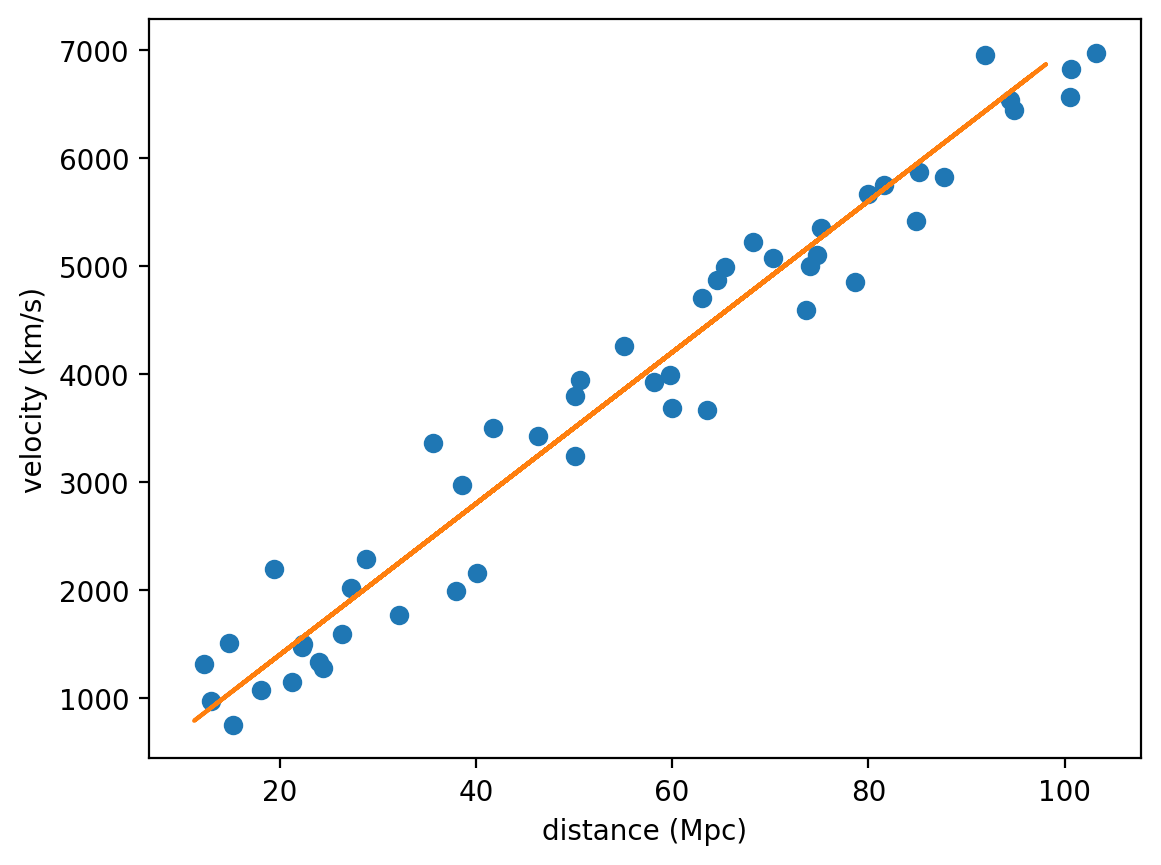

In [3]:
plt.plot(Dobs, vr, ls = 'None', marker = 'o')
plt.plot(D, vH)

plt.xlabel('distance (Mpc)')
plt.ylabel('velocity (km/s)')

plt.show()

Our observables are $D_{\rm obs}$ and $v_r$. 

The parameters we want to infer are:
* population-level parameters: $H_0$, $\sigma_p$ 
* event-level parameters: $D$, $v_p$, and $v_H$.

We also have some fixed parameters: $D_\mathrm{min}$, $D_\mathrm{max}$, $\sigma_D$

A probabilistic model makes it easy to keep track of the relationships between the different parameters. 

In [4]:
def model(Dobs, vr, Dmin = Dmin, Dmax = Dmax, sigmaD = sigmaD):
    
    # define priors for parameters we're fitting. Priors should be from numpyro.distributions module. 
    # For population-level parameters, you can choose whatever priors you want.
    # I was lazy and chose uniform distributions but you can be more thoughtful in your research!
    H0 = numpyro.sample("H0", dist.Uniform(50,140))
    sigmap = numpyro.sample("sigmap", dist.Uniform(0, 1000))

    # Below we define the likelihood function
    # numpyro.plate indicates that the data are independent
    with numpyro.plate("data", len(Dobs)):
        
        # this is our prior for individual source distances. 
        # We are kind of cheating -- we know what it should be because we generated the data.
        # Often we would fit for the distribution of true distances across all events as another set of population parameters. 
        #(e.g. defining priors for Dmin and Dmax above)
        D = numpyro.sample("D", dist.Uniform(Dmin, Dmax)) 
        
        numpyro.sample("Dobs", dist.Normal(D, sigmaD), obs = Dobs)

        # You can track transformed parameters and other helpful quantities during sampling with "deterministic" as follows:
        vH = numpyro.deterministic("vH", H0*D)

        numpyro.sample("vp", dist.Normal(0, sigmap), obs = vr - vH)

In [5]:
# we sample from the model above using the NUTS sampler
sampler = infer.MCMC(
    infer.NUTS(model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(0), Dobs, vr)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [6]:
samples = sampler.get_samples()

Let's also draw samples from the prior:

In [7]:
prior_samples = infer.Predictive(model, num_samples=4000)(
    jax.random.PRNGKey(0), Dobs, vr)

In [8]:
samples.keys()

dict_keys(['D', 'H0', 'sigmap', 'vH'])

In [9]:
samples['D'].shape, samples['vH'].shape

((4000, 50), (4000, 50))

Note that we get posterior samples for the event-level parameters (distance and Hubble-flow velocity for each event; e.g. `D[:,i]`, for i between 0 and 49 and similarly for vH) as well as the population-level parameters H0 and sigmap. 

By stacking multiple events, we get knowledge of the population-level parameters that update our inference of individual-event parameters.
For example, let's look at our "population-informed" posterior on the Hubble-flow velocity of event $i=10$ compared to the prior:

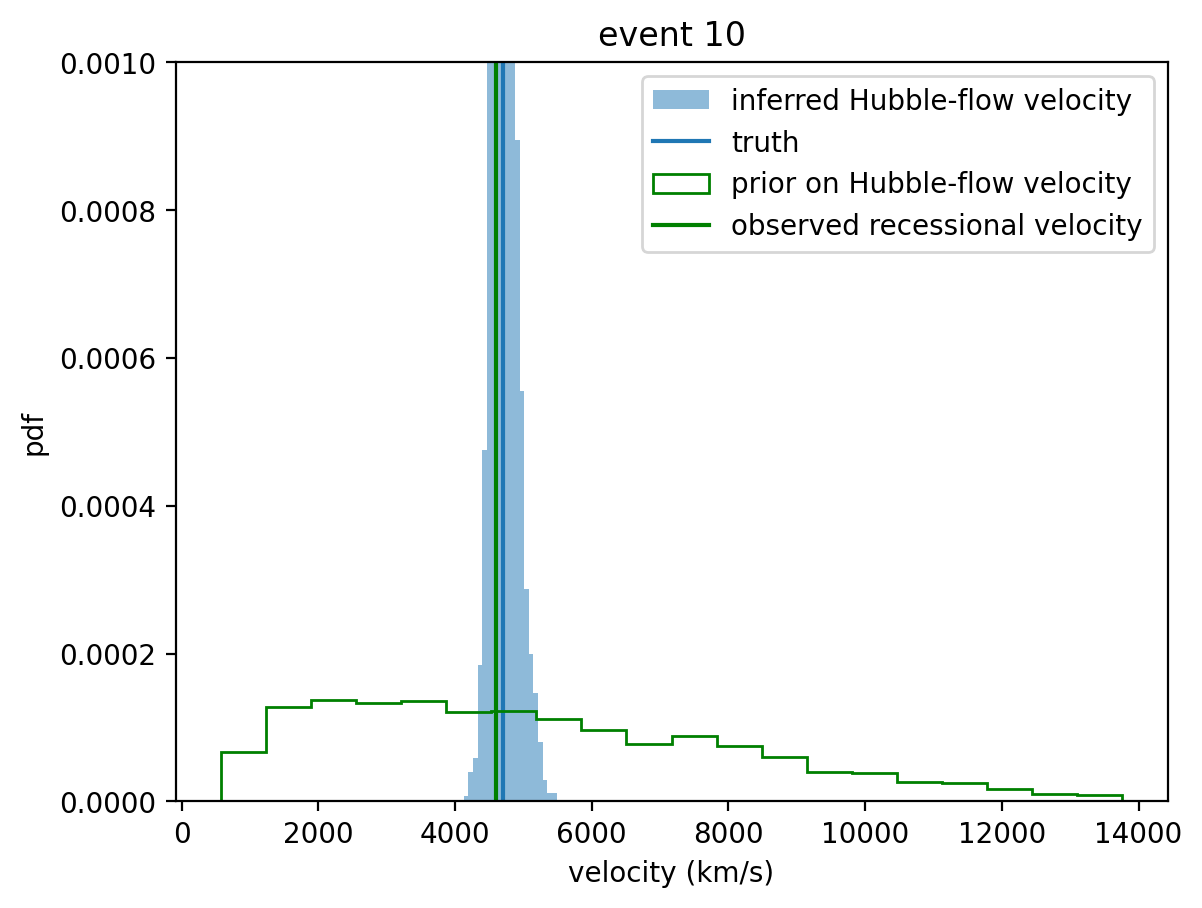

In [11]:
i=10
plt.hist(samples['vH'][:,i], density = True, bins = 20, alpha = 0.5, label = 'inferred Hubble-flow velocity')
plt.axvline(vH[i], label = 'truth')

plt.hist(prior_samples['vH'][:,i], density = True, bins = 20, histtype = 'step', color = 'g', label = 'prior on Hubble-flow velocity')
plt.axvline(vr[i], c = 'g', label = 'observed recessional velocity')

plt.legend(loc = 'best')
plt.xlabel('velocity (km/s)')
plt.ylabel('pdf')

plt.ylim(0,0.001)

plt.title(f'event {i}')
plt.show()

Let's plot the posterior samples for H0 and sigmap as a corner plot:

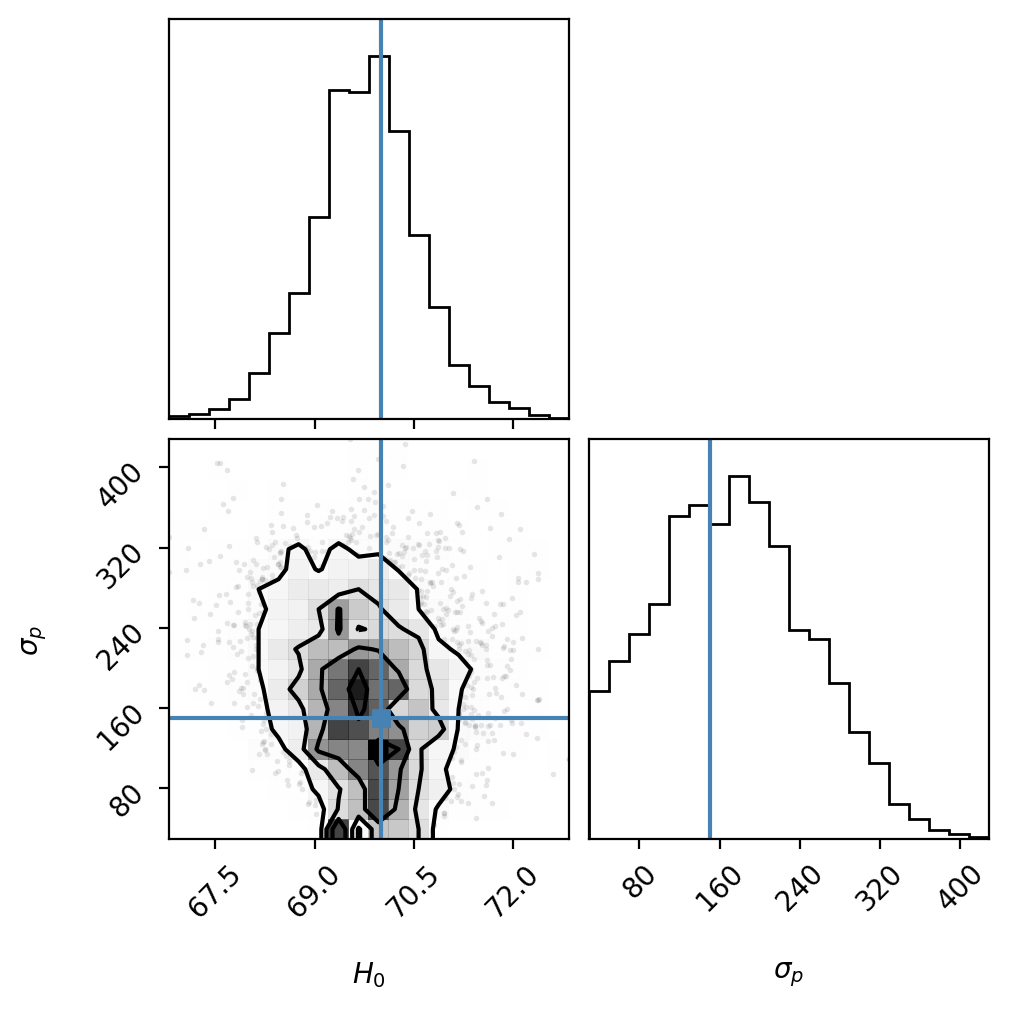

In [12]:
corner.corner(np.column_stack([samples[n] for n in ['H0', 'sigmap']]), labels = [r'$H_0$', r'$\sigma_p$'], truths = [H0, sigmap]);

We can use [arviz](https://python.arviz.org/en/stable/getting_started/index.html) to calculate summary statistics (e.g., mean and standard deviation) and check convergence of our chain; e.g., Gelman–Rubin statistic (r_hat, which we want to be close to 1), and the effective sample sizes (ess_bulk, which we want to be fairly large):

In [13]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data,  var_names=["H0", "sigmap"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H0,69.763,0.809,68.129,71.223,0.026,0.016,941.0,1905.0,1.00
sigmap,172.873,75.190,42.357,305.816,6.403,2.669,123.0,93.0,1.01


NumPyro's interface meant we could build a probabistic model without actually writing down our likelihood.
It's generally good practice to write down your likelihood anyway, and for some problems you will need to use a custom likelihood because you want to sample from distributions that are not predefined in NumPyro. 
To sample from a custom likelihood, you can use use `numpyro.factor` to add an arbitrary log probability to your model (the argument of numpyro.factor is your *log* probability). 

For this example, the joint probability of the data $\{D_{\mathrm{obs}, i}\}$ and $\{v_{r,i} \}$, jointly with single-event parameters $\{D_i\}$ and population-level parameters $H_0$ and $\sigma_p$ is:
$$
p(\{D_{\mathrm{obs}, i}\}, \{v_{r,i} \}, \{D_i\}, H_0, \sigma_p) = 
\Pi_{i=1}^{N} p(D_{{\rm obs}, i} | D_i)  p(v_{r, i} | \sigma_p, H_0, D_i) p(D_i) p(H_0) p(\sigma_p)
$$

The first factor in the product is a Normal pdf with mean $D_i$ and known standard deviation $\sigma_D$. 
The second factor is a Normal pdf with mean $H_0 * D_i$ and standard deviation $\sigma_p$.
The third term is our prior over $D_i$, which is uniform between $D_\mathrm{min}$ and $D_\mathrm{max}$. 
The last two terms are our priors over $H_0$ and $\sigma_p$.

(We've dropped single-event parameters $\{v_{H,i}\}$ because they are deterministic given $H_0$ and $D_i$.)

If we are interested only in the posterior over $H_0$ and $\sigma_p$, given $\{D_{\mathrm{obs}, i}\}$ and $\{v_{r,i} \}$, we can use Bayes theorem and marginalize over $\{D_i\}$, as follows:

$$
p(H_0, \sigma_p | \{D_{\mathrm{obs}, i}\}, \{v_{r,i} \}) = \int d\{D_i\} p(H_0, \sigma_p, \{D_i\} | \{D_{\mathrm{obs}, i}\}, \{v_{r,i} \})
$$ 
where 
$$
p(H_0, \sigma_p, \{D_i\} | \{D_{\mathrm{obs}, i}\}, \{v_{r,i} \}) = \frac{p(\{D_{\mathrm{obs}, i}\}, \{v_{r,i} \}, \{D_i\}, H_0, \sigma_p)}{p ( \{D_{\mathrm{obs}, i}\}, \{v_{r,i} \})} \propto p(\{D_{\mathrm{obs}, i}\}, \{v_{r,i} \}, \{D_i\}, H_0, \sigma_p)
$$
